
# Model checks, model selection, and multivariate distributions

This page focuses on **posterior predictive checks**, three approaches to **model selection**,
and a quick tour of **multivariate** Bayesian ideas.


## Utilities

In [13]:

import math
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

def with_ax(title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

def hdi_interval(samples, prob=0.9):
    # Simple HDI via shortest interval on sorted samples
    x = np.sort(np.asarray(samples))
    n = len(x)
    m = max(1, int(np.floor(prob * n)))
    widths = x[m:] - x[:n-m]
    j = int(np.argmin(widths))
    return float(x[j]), float(x[j+m])

def poisson_pmf(k, lam):
    # k can be array-like
    k = np.asarray(k)
    from math import lgamma, exp
    out = np.zeros_like(k, dtype=float)
    mask = k >= 0
    km = k[mask]
    out[mask] = np.exp(km*np.log(lam) - lam - np.array([lgamma(int(kk)+1) for kk in km]))
    return out

def nb_pmf(k, r, p):
    # Negative Binomial (failures k before r successes), PMF: C(k+r-1, k) (1-p)^k p^r
    # mean = r(1-p)/p, var = r(1-p)/p**2
    from math import lgamma
    k = np.asarray(k, dtype=int)
    out = np.zeros_like(k, dtype=float)
    mask = k >= 0
    km = k[mask]
    logC = np.array([lgamma(r+kk) - lgamma(kk+1) - lgamma(r) for kk in km])
    out[mask] = np.exp(logC + km*np.log(1-p) + r*np.log(p))
    return out

def dirichlet_sample(alpha, size=1, rng=None):
    if rng is None: rng = np.random.default_rng()
    x = rng.gamma(alpha, 1.0, size=(size, len(alpha)))
    x = x / x.sum(axis=1, keepdims=True)
    return x.squeeze()



## Posterior predictive checks on maternity ward counts

**Data (20 days)** from the slides:  
$y = [7, 8, 3, 7, 11, 7, 9, 19, 7, 15, 9, 5, 12, 3, 7, 6, 5, 3, 11, 5]$  fileciteturn4file0

We'll compare a **Poisson** likelihood vs a more flexible **Negative Binomial**.


In [14]:

y = np.array([7, 8, 3, 7, 11, 7, 9, 19, 7, 15, 9, 5, 12, 3, 7, 6, 5, 3, 11, 5], dtype=int)
n = len(y)
y_mean, y_var = float(y.mean()), float(y.var(ddof=1))
y_mean, y_var


(7.95, 16.681578947368422)


### Poisson model with Gamma prior (conjugate)
Choose a weakly informative prior on the intensity $\lambda \sim \mathrm{Gamma}(s_0, r_0)$ in **shape–rate** form.

Posterior: $\lambda \mid y \sim \mathrm{Gamma}\!\big(s_0 + \textstyle\sum y_i,\ r_0 + n\big)$.  
Posterior predictive (for a new $y_{\text{new}}$) is **Negative Binomial**.


In [15]:

def gamma_post_params_poisson(s0, r0, y):
    return s0 + y.sum(), r0 + len(y)

def sample_posterior_predictive_poisson(y, s0=1.0, r0=1.0, draws=2000, rng=None):
    if rng is None: rng = np.random.default_rng()
    sN, rN = gamma_post_params_poisson(s0, r0, y)
    lam_samps = rng.gamma(shape=sN, scale=1.0/rN, size=draws)
    # simulate replicated datasets of size n
    yrep = [rng.poisson(lam, size=len(y)) for lam in lam_samps]
    return np.array(yrep), lam_samps

yrep_pois, lam_samps = sample_posterior_predictive_poisson(y, s0=1.8, r0=1.0, draws=3000, rng=rng)
# Compare means/variances across replicated datasets
means_pois = yrep_pois.mean(axis=1)
vars_pois  = yrep_pois.var(axis=1, ddof=1)
(float(means_pois.mean()), float(vars_pois.mean()))


(7.658899999999999, 7.647628070175439)

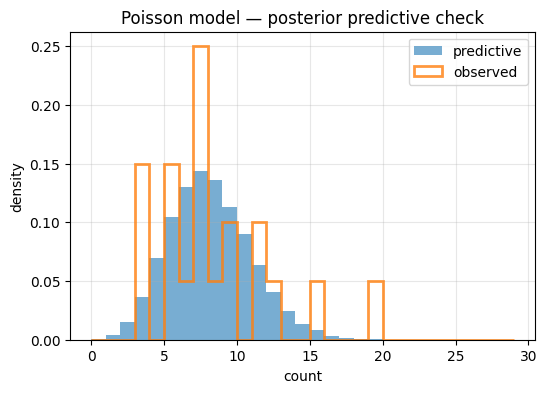

In [16]:

# Visual comparison: observed vs posterior predictive (Poisson model)
fig, ax = with_ax(title="Poisson model — posterior predictive check", xlabel="count", ylabel="density")
# Collate predictive counts into a long array
ax.hist(yrep_pois.ravel(), bins=range(0, 30), density=True, alpha=0.6, label="predictive")
ax.hist(y, bins=range(0, 30), density=True, alpha=0.8, histtype="step", linewidth=2, label="observed")
ax.legend(); plt.show()



The Poisson model ties variance to the mean. If data variance $>$ mean, the predictive may appear **too narrow**
(under-dispersed), matching the slide intuition. fileciteturn4file0



### Negative Binomial model (method-of-moments fit)

Use the parameterization with mean $\mu$ and overdispersion $\alpha$ where $\operatorname{Var}(Y)=\mu + \alpha \mu^2$.  
A quick estimate is
$$
\hat\mu=\bar y,\qquad \hat\alpha=\max\!\left(0,\ \frac{s^2 - \bar y}{\bar y^2}\right),
$$
with $s^2$ the sample variance. We’ll simulate a predictive from this fitted NB as a **demonstration**.
A full Bayesian NB would add priors on $(\mu,\alpha)$ and increase epistemic uncertainty (as in the slides). fileciteturn4file0


In [17]:

def mom_nb_mu_alpha(y):
    mu = float(y.mean())
    s2 = float(y.var(ddof=1))
    alpha = max(0.0, (s2 - mu)/(mu**2 + 1e-15))
    return mu, alpha

def nb_params_from_mu_alpha(mu, alpha):
    # Convert to (r, p) for failures-before-r-successes PMF
    # mean = r(1-p)/p = mu, var = mu + alpha mu^2 => solves to:
    if alpha <= 0:
        # reduce to Poisson in limit; approximate with large r
        r = 1e6
        p = r/(r+mu)
        return r, p
    r = 1.0/alpha
    p = r/(r+mu)
    return r, p

mu_hat, alpha_hat = mom_nb_mu_alpha(y)
r_hat, p_hat = nb_params_from_mu_alpha(mu_hat, alpha_hat)

# Posterior predictive (plug-in) — simulate replicated datasets
def simulate_nb_predictive(y, r, p, draws=3000, rng=None):
    if rng is None: rng = np.random.default_rng()
    # NB as failures before r successes; to match counts, use that form:
    yrep = []
    for _ in range(draws):
        # sample n new counts
        yr = rng.negative_binomial(r, p, size=len(y))
        yrep.append(yr)
    return np.array(yrep)

yrep_nb = simulate_nb_predictive(y, r_hat, p_hat, draws=3000, rng=rng)
means_nb = yrep_nb.mean(axis=1)
vars_nb  = yrep_nb.var(axis=1, ddof=1)
(float(means_nb.mean()), float(vars_nb.mean())), (mu_hat, alpha_hat, r_hat, p_hat)


((7.944533333333333, 16.59651052631579),
 (7.95, 0.13815242984642098, 7.2383815551537065, 0.47657359204921906))

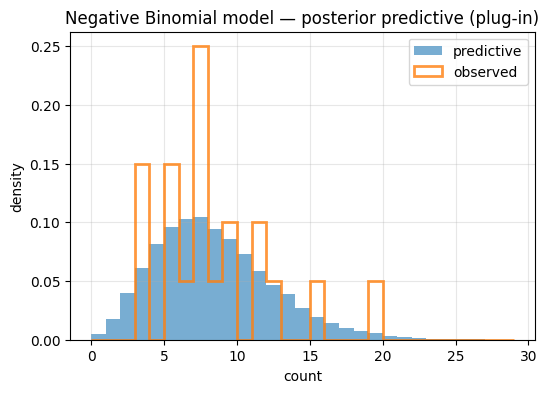

In [18]:

# Visual comparison: observed vs NB predictive
fig, ax = with_ax(title="Negative Binomial model — posterior predictive (plug-in)", xlabel="count", ylabel="density")
ax.hist(yrep_nb.ravel(), bins=range(0, 30), density=True, alpha=0.6, label="predictive")
ax.hist(y, bins=range(0, 30), density=True, alpha=0.8, histtype="step", linewidth=2, label="observed")
ax.legend(); plt.show()



You should see that the NB predictive is typically **wider** than Poisson, helping when data are **overdispersed**.  
The slides show this improvement and note the trade-off: an extra parameter increases **epistemic** uncertainty. fileciteturn4file0



## Model selection: three complementary lenses

We implement lightweight versions of the three approaches in the slides:
- **Bayes factor / marginal likelihood** for the Poisson–Gamma model (analytic). fileciteturn4file0  
- **ELPD/LOO** via leave-one-out log predictive density (exact for Poisson–Gamma; plug-in for NB). fileciteturn4file0  
- **Classical errors generalized**: average RMSE/MAE over the posterior predictive (or plug-in predictive). fileciteturn4file0


In [19]:

from math import lgamma

def log_marginal_likelihood_poisson_gamma(y, s0=1.8, r0=1.0):
    # Integrate out λ under Gamma prior; closed form for Poisson-Gamma
    y = np.asarray(y, dtype=int)
    n = len(y)
    S = int(y.sum())
    # Product of 1/k! terms
    log_fact_sum = np.sum([lgamma(int(kk)+1) for kk in y])
    sN, rN = s0 + S, r0 + n
    # log evidence up to exact constants (including factorials)
    return -log_fact_sum + s0*np.log(r0) - lgamma(s0) + lgamma(sN) - sN*np.log(rN)

log_evid_poisson = log_marginal_likelihood_poisson_gamma(y, s0=1.8, r0=1.0)
log_evid_poisson


-62.40085712687636


For a **Negative Binomial** likelihood, analytic marginal likelihood with convenient priors is less friendly.  
We will therefore compare **predictive** performance (ELPD) and **RMSE/MAE** next.



### ELPD via leave-one-out

For Poisson–Gamma, $p(y_i \mid y_{-i})$ is **analytic**: conjugate posterior using all-but-one data, then predictive (Poisson–Gamma gives NB predictive).  
For NB (plug-in), we re-fit $(\mu,\alpha)$ by method-of-moments on $y_{-i}$ and evaluate the NB pmf at $y_i$.


In [20]:

def loo_elpd_poisson_gamma(y, s0=1.8, r0=1.0):
    y = np.asarray(y, dtype=int)
    elpds = []
    for i in range(len(y)):
        y_loo = np.delete(y, i)
        sN, rN = gamma_post_params_poisson(s0, r0, y_loo)
        # predictive for y[i] is NB with params (sN, rN/(1+rN)) in 'failures before sN successes' form
        # But easier: integrate directly: p(y|sN,rN) = ∫ Poisson(λ) Gamma(λ|sN,rN) dλ
        # This equals: Gamma-Poisson mixture, closed form using gamma functions
        k = int(y[i])
        log_pred = (lgamma(sN + k) - lgamma(sN) - lgamma(k+1) +
                    sN*np.log(rN) - (sN+k)*np.log(rN + 1))
        elpds.append(log_pred)
    return float(np.sum(elpds)), np.array(elpds)

def loo_elpd_nb_plugin(y):
    y = np.asarray(y, dtype=int)
    elpds = []
    for i in range(len(y)):
        y_loo = np.delete(y, i)
        mu, alpha = mom_nb_mu_alpha(y_loo)
        r, p = nb_params_from_mu_alpha(mu, alpha)
        k = int(y[i])
        # NB pmf for failures before r successes at probability p
        logC = lgamma(r+k) - lgamma(k+1) - lgamma(r)
        log_pred = logC + k*np.log(1-p) + r*np.log(p)
        elpds.append(log_pred)
    return float(np.sum(elpds)), np.array(elpds)

elpd_pois, _ = loo_elpd_poisson_gamma(y, s0=1.8, r0=1.0)
elpd_nb, _   = loo_elpd_nb_plugin(y)
(elpd_pois, elpd_nb)


(-58.42205107960177, -56.738495810564885)


### Generalized RMSE/MAE

Compute average error over **posterior predictives** (Poisson–Gamma) and over **NB plug-in** predictives.


In [21]:

def rmse_mae_vs_predictive(y, yrep):
    # yrep: draws x n array of replicated datasets
    diffs = yrep - y[None, :]
    rmse = np.sqrt((diffs**2).mean())
    mae  = np.abs(diffs).mean()
    return float(rmse), float(mae)

rmse_pois, mae_pois = rmse_mae_vs_predictive(y, yrep_pois)
rmse_nb,   mae_nb   = rmse_mae_vs_predictive(y, yrep_nb)
(rmse_pois, mae_pois), (rmse_nb, mae_nb)


((4.893509306554279, 3.7632), (5.713300272171944, 4.4156))


**Note:** It's common for these three lenses to disagree in small-sample settings, as the slides discuss. fileciteturn4file0



## Multivariate quick tour

We touch three topics from the slides:
- **Covariance and correlation** from data matrices. fileciteturn4file0  
- **Dirichlet–Multinomial** for multi-class counts (election mini-example). fileciteturn4file0  
- **Multivariate Normal**: estimate mean/covariance and sample synthetic data.



### Covariance and correlation from data

Given a matrix $X \in \mathbb{R}^{n\times p}$ (rows are observations, columns are features), the empirical covariance is
$$
\Sigma = \frac{1}{n-1} (X - \bar X)^\top (X - \bar X),\qquad
\rho_{ij}=\frac{\Sigma_{ij}}{\sqrt{\Sigma_{ii}\Sigma_{jj}}}.
$$


In [22]:

X = rng.normal(size=(200, 3))
# Induce correlation roughly
X[:,1] = 0.6*X[:,0] + 0.4*rng.normal(size=200)
X[:,2] = -0.5*X[:,0] + 0.2*rng.normal(size=200)

Xc = X - X.mean(axis=0, keepdims=True)
Sigma = (Xc.T @ Xc) / (len(X)-1)
D = np.sqrt(np.diag(Sigma))
Corr = Sigma / (D[:,None]*D[None,:])

Sigma, Corr


(array([[ 0.91610398,  0.5554934 , -0.4684915 ],
        [ 0.5554934 ,  0.49044278, -0.28213379],
        [-0.4684915 , -0.28213379,  0.27850919]]),
 array([[ 1.        ,  0.82872863, -0.92749069],
        [ 0.82872863,  1.        , -0.76338066],
        [-0.92749069, -0.76338066,  1.        ]]))


### Dirichlet–Multinomial election example

Counts: Alice=7, Bob=22, Claire=11 (from slides). Use a flat $\mathrm{Dirichlet}(1,1,1)$ prior, update to $\mathrm{Dirichlet}(8,23,12)$,  
and visualize posterior draws and a few posterior predictive elections of size $n=40$. fileciteturn4file0


In [23]:

alpha0 = np.array([1.0, 1.0, 1.0])
k = np.array([7,22,11])
alphaN = alpha0 + k

# Posterior samples over probabilities
theta_samps = dirichlet_sample(alphaN, size=5000, rng=rng)
theta_mean = theta_samps.mean(axis=0)

# Posterior predictive: sample multinomial counts for new poll of size 40
def multinomial_rng(n, p, rng=None):
    if rng is None: rng = np.random.default_rng()
    # use categorical draws
    cats = rng.choice(len(p), size=n, p=p)
    counts = np.bincount(cats, minlength=len(p))
    return counts

yrep = np.array([multinomial_rng(40, th, rng=rng) for th in theta_samps[:2000]])
theta_mean, yrep[:5]


(array([0.18581989, 0.53615127, 0.27802883]),
 array([[18, 16,  6],
        [17, 16,  7],
        [13, 12, 15],
        [ 7, 18, 15],
        [11, 13, 16]]))

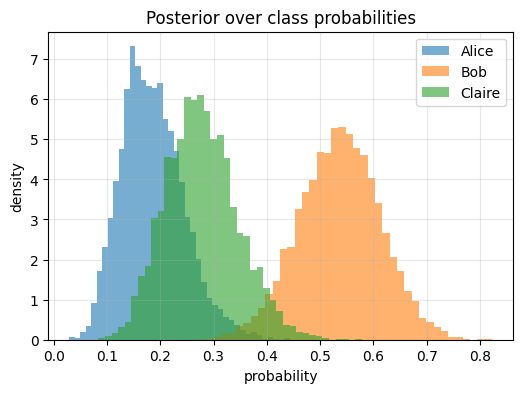

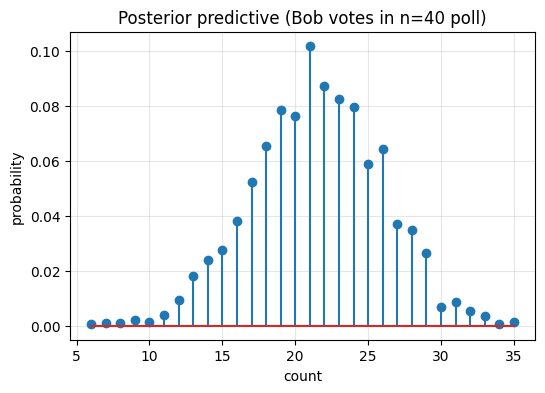

In [24]:

# Visual: posterior mass over the 3-simplex projected as histograms of each component
fig, ax = with_ax(title="Posterior over class probabilities", xlabel="probability", ylabel="density")
ax.hist(theta_samps[:,0], bins=40, density=True, alpha=0.6, label="Alice")
ax.hist(theta_samps[:,1], bins=40, density=True, alpha=0.6, label="Bob")
ax.hist(theta_samps[:,2], bins=40, density=True, alpha=0.6, label="Claire")
ax.legend(); plt.show()

# Visual: posterior predictive distribution of 'Bob' counts in a new poll of size 40
fig, ax = with_ax(title="Posterior predictive (Bob votes in n=40 poll)", xlabel="count", ylabel="probability")
vals, cnts = np.unique(yrep[:,1], return_counts=True)
ax.stem(vals, cnts/cnts.sum()) #, use_line_collection=True); plt.show()
plt.show()


### Multivariate Normal: fit and sample synthetic data

Given data $Z\in\mathbb{R}^{n\times p}$, estimate $\hat\mu$ and $\hat\Sigma$ (empirical), then sample synthetic $Z_{\text{new}}\sim \mathcal{N}(\hat\mu,\hat\Sigma)$.
This is the basic ingredient behind using MVN for **density estimation / data augmentation**, as discussed in the slides. fileciteturn4file0


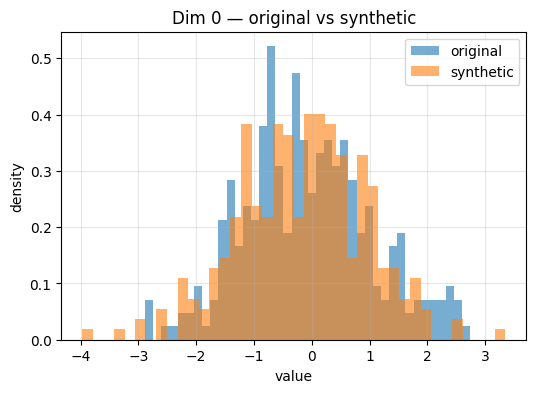

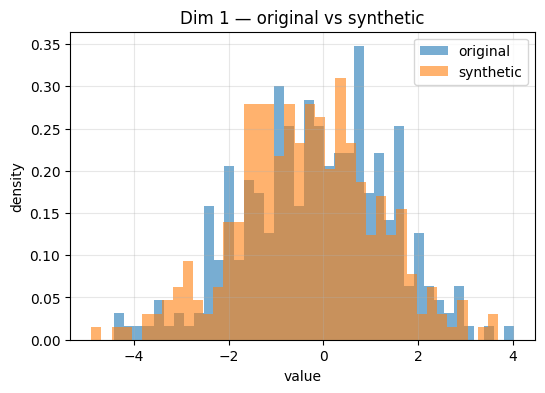

(array([-0.0672264 , -0.14294515]),
 array([[1.21798687, 1.19755436],
        [1.19755436, 2.29107094]]))

In [25]:

Z = rng.normal(size=(300, 2)) @ np.array([[1.0, 0.5],[0.5, 1.5]])  # correlated 2D data
mu_hat = Z.mean(axis=0)
Zc = Z - mu_hat
Sigma_hat = (Zc.T @ Zc) / (len(Z)-1)

# Sample synthetic data
Z_new = rng.multivariate_normal(mean=mu_hat, cov=Sigma_hat, size=300)

# Plot each dimension histogram to sanity check
for j in range(Z.shape[1]):
    fig, ax = with_ax(title=f"Dim {j} — original vs synthetic", xlabel="value", ylabel="density")
    ax.hist(Z[:,j], bins=40, density=True, alpha=0.6, label="original")
    ax.hist(Z_new[:,j], bins=40, density=True, alpha=0.6, label="synthetic")
    ax.legend(); plt.show()

mu_hat, Sigma_hat



## Key takeaways
- **Posterior predictive checks** confront your model with data; overdispersion often calls for **Negative Binomial** rather than Poisson. fileciteturn4file0  
- **Model selection** has multiple valid lenses (Bayes factor, ELPD/LOO, RMSE/MAE) that can disagree with small data — that’s signal, not failure. fileciteturn4file0  
- **Multivariate** work adds covariance/correlation structure; Dirichlet–Multinomial is the categorical analogue of Beta–Binomial; MVN can seed simple data augmentation. fileciteturn4file0

Try editing priors, sample sizes, and model choices above to see how conclusions shift.
